This notebook provides tutorials for the following decoding setup:

1. **(Custom dataset)** users provide their own spike features and behaviors
    
2. **(IBL)** work with public IBL datasets

3. **(CAVI)** example usage for binary behavioral correlates

In [1]:
import os
import sys
import time
import random
import numpy as np
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.io import loadmat
from sklearn.model_selection import train_test_split

from density_decoding.utils.utils import set_seed

from density_decoding.utils.data_utils import (
    BaseDataLoader,
    IBLDataLoader, 
)
from density_decoding.decoders.behavior_decoder import (
    generic_decoder,
    sliding_window_decoder
)
from density_decoding.decode_pipeline import decode_pipeline

set_seed(666)

device = torch.device("cpu")

In [2]:
%matplotlib inline
plt.rc("figure", dpi=400)
SMALL_SIZE = 12.5
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

#### 1. Custom dataset

In this section, we provide a tutorial for running density-based decoding on your own data.

Here we use an example from a Neuropixel 1.0 in non-human primates (NP1-NHP) recording in a monkey dataset.

First, let's load the **spike times**, **spike channels** and **spike features**. 

In [3]:
dir_path = Path("/mnt/3TB/yizi/np1_nhp")
# use your own sampling frequency
sampling_freq = 30_000    
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T
# convert spike times from the unit of time samples to seconds
spike_times = spike_times / sampling_freq

**Note:** To get `spike_index.npy` and `localization_results.npy`, we need to run **[dartsort](https://github.com/cwindolf/dartsort)** (our spike detection and localization pipeline).

Let's visualize the following spike features:
- location on the probe
- maximum peak-to-peak (maxptp) amplitude

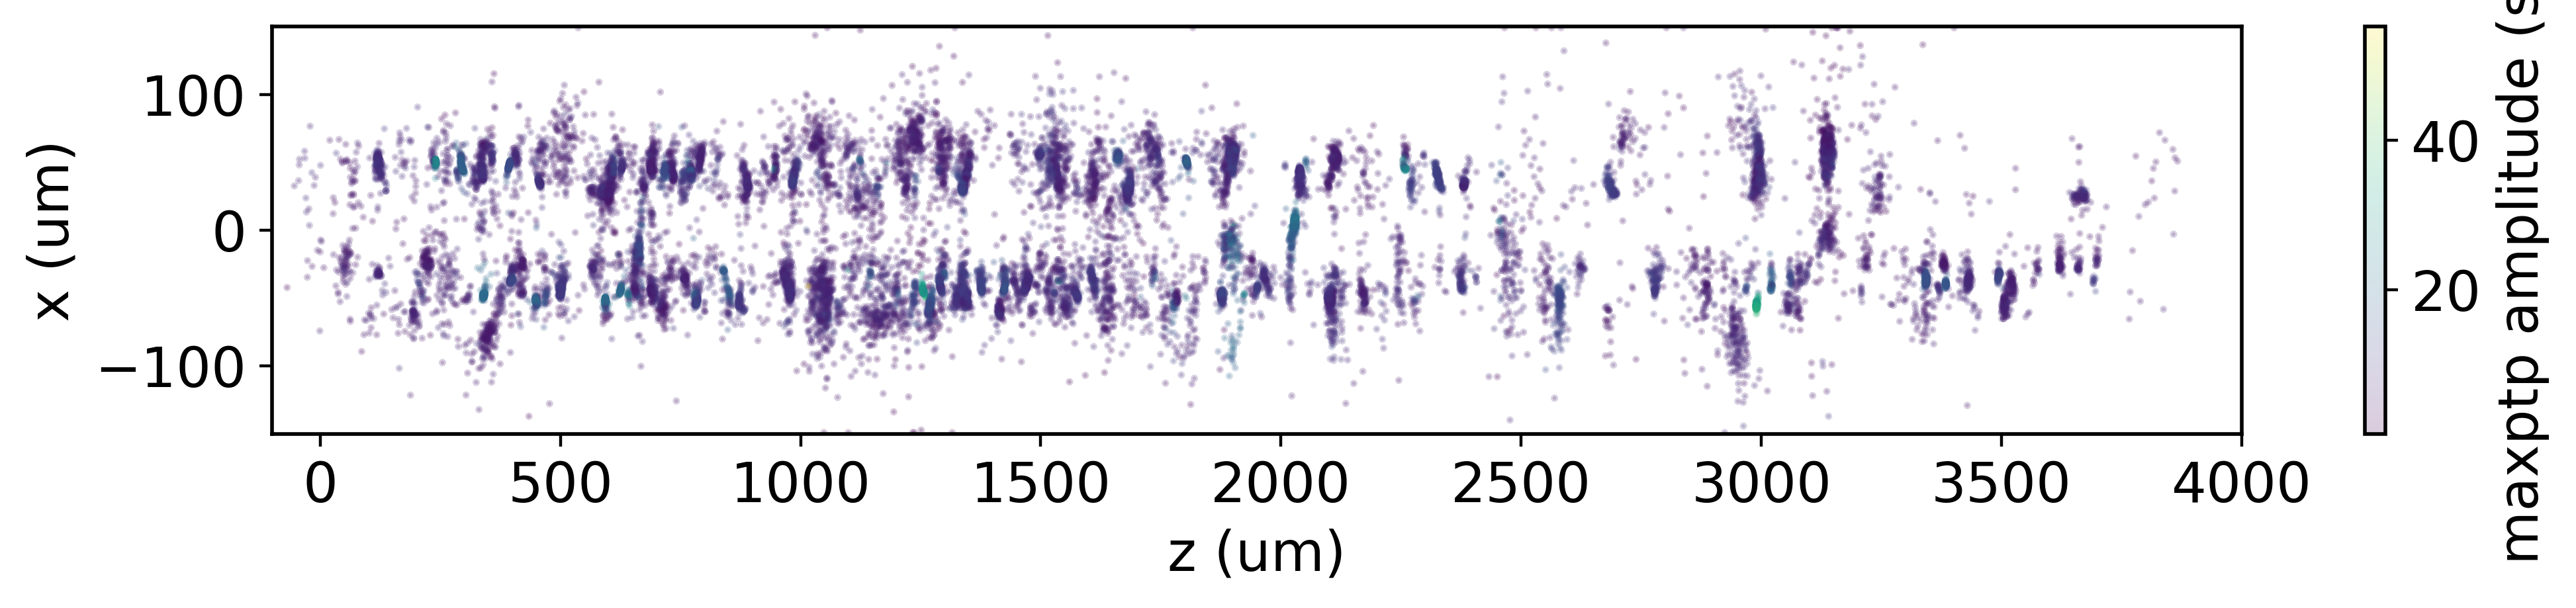

In [4]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-150, 150)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

Then, we load the **behavioral correlate** that we want to decode:

In [5]:
# we only decode the force along the y direction
behavior_mat = loadmat(dir_path / "force.mat")["force"]
behavior = [behavior_mat[i].item()[1].T for i in range(len(behavior_mat))]
raw_behaviors = np.concatenate(behavior)

# we only decode trials from either positive or negative gains
gain_mat = loadmat(dir_path / "gain.mat")
gain = np.array([gain_mat["gain"][i].item().item() for i in range(len(gain_mat["gain"]))])

To allocate spike features and behavioral correlate into trials, we load and prepare the **trial start and end times**:

In [6]:
simTime_mat = loadmat(dir_path / "simTime.mat")["simTime"]
trial_times = [simTime_mat[i].item().T for i in range(len(simTime_mat))]
trial_start_times = [trial_times[i][0] for i in range(len(trial_times))]
trial_end_times = [trial_times[i][-1] for i in range(len(trial_times))]
time_points = np.concatenate(trial_times)

Next, we prepare a custom data loader to convert spike features and behavioral correlate into the required format for the decoding pipeline:

In [7]:
custom_data_loader = BaseDataLoader(
    # use your own trial length (sec)
    trial_length = 9.85, 
    n_t_bins = 30
)

In [8]:
bin_behaviors = custom_data_loader.process_behaviors(
    time_points,
    raw_behaviors, 
    trial_start_times,
    trial_end_times,
)

Process behaviors:  32%|███████▏              | 102/314 [00:01<00:02, 80.63it/s]/home/yizi/density_decoding/density_decoding/utils/data_utils.py:134: RuntimeWarning: Mean of empty slice.
  bin_behaviors[k, t] = sub_behaviors[t_bin_mask == t, 1].mean()
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Process behaviors: 100%|██████████████████████| 314/314 [00:03<00:00, 80.26it/s]


Before filtering out the positive gains, this dataset has 314 trials.

In [9]:
bin_behaviors.shape

(314, 30)

We compare the raw behavior to the preprocessed behavior:

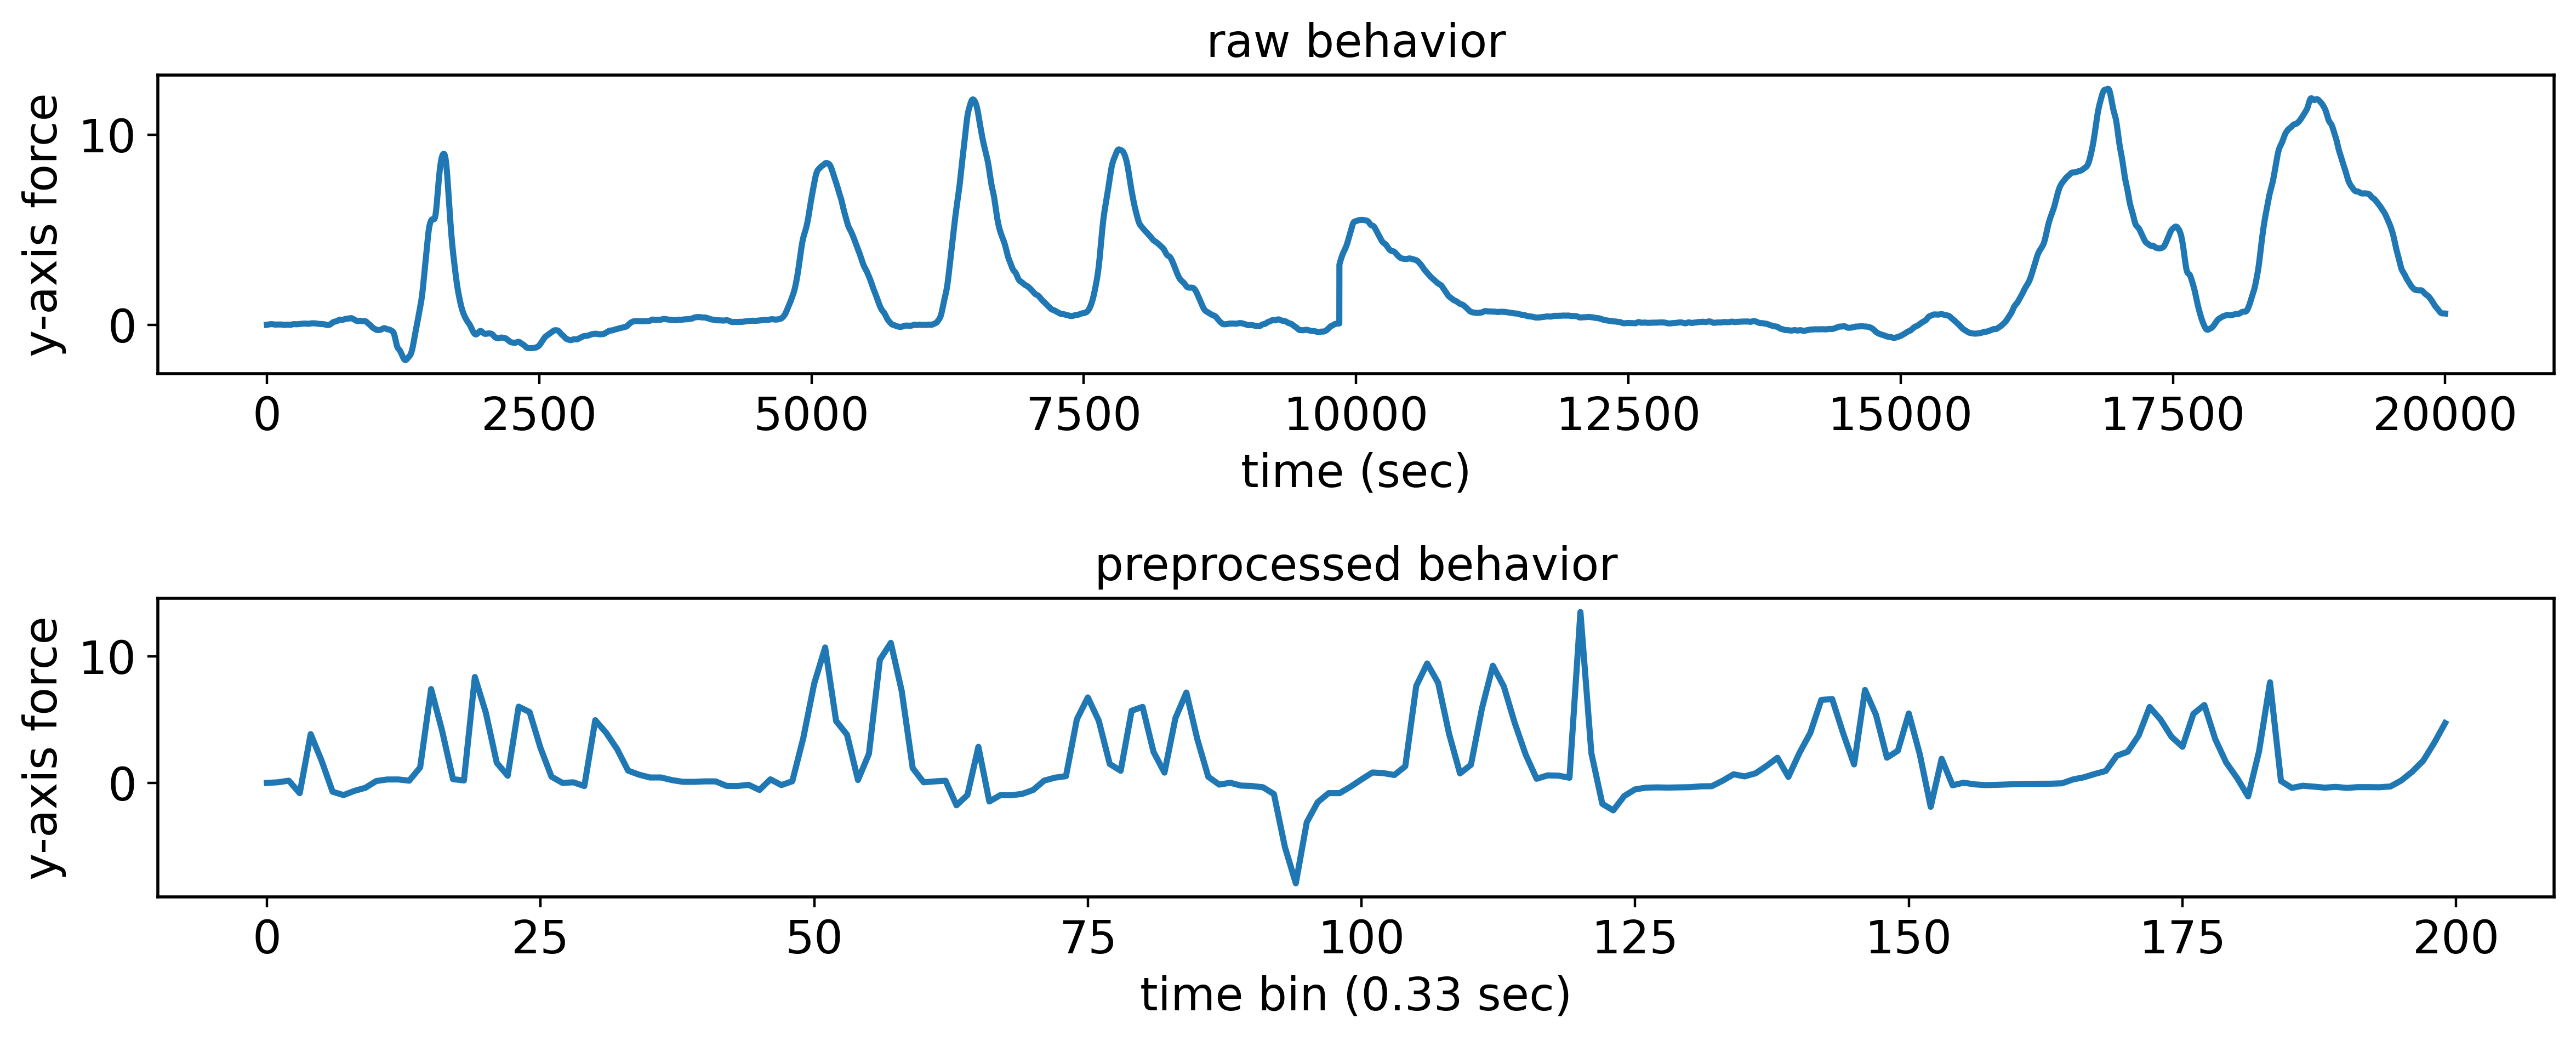

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
ax1.plot(raw_behaviors[:20_000], linewidth=2)
ax1.set_title("raw behavior")
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("y-axis force")
ax2.plot(bin_behaviors.flatten()[:200], linewidth=2)
ax2.set_title("preprocessed behavior")
ax2.set_xlabel("time bin (0.33 sec)")
ax2.set_ylabel("y-axis force")
plt.tight_layout()
plt.show()

Then we filter out trials with missing behaviors and from the negative gains. 

In [11]:
filtered_trials = np.intersect1d(
    np.argwhere(np.sum(np.isnan(bin_behaviors), 1) == 0), 
    np.argwhere(gain == -1)
)
# only decode the first 50 trials for demo purposes
filtered_trials = filtered_trials[:50]
bin_behaviors = bin_behaviors[filtered_trials]
print(bin_behaviors.shape)

(50, 30)


Next, we convert spike features into the required input format:

In [12]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    custom_data_loader.process_spike_features(
        spike_times,
        spike_channels,
        spike_features, 
        trial_start_times,
        trial_end_times,
        valid_trials = filtered_trials
    )

Process spike features: 100%|███████████████████| 50/50 [00:03<00:00, 15.01it/s]


Before launching our decoding pipeline, we need the **thresholding** spike count matrix:

In [13]:
thresholded_spike_count = custom_data_loader.compute_spike_count_matrix(
    spike_times, 
    spike_channels, 
    trial_start_times,
    trial_end_times,
    valid_trials = filtered_trials
)

Compute spike count: 100%|██████████████████████| 50/50 [00:03<00:00, 16.15it/s]


In [14]:
print(thresholded_spike_count.shape)

(50, 384, 30)


**Now we are ready to start density-based decoding!**

Let's split the trials into train and test sets:

In [15]:
trial_idxs = np.arange(len(bin_behaviors))
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

In [16]:
start_time = time.time()

weight_matrix = decode_pipeline(
    custom_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors,
    behavior_type = "continuous",
    train = train,
    test = test,
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|█████████████████████████| 383/383 [00:31<00:00, 12.33it/s]


Initialized a mixture with 566 components.


Train ADVI: 100%|█████████████████████████████| 500/500 [20:37<00:00,  2.48s/it]


time spent: 1304.0307219028473 seconds


In [17]:
_, y_test, our_pred, metrics = sliding_window_decoder(
    weight_matrix, bin_behaviors, train, test, behavior_type="continuous"
)

R2: 0.636, MSE: 2.913, Corr: 0.802


To compare to **spike-sorted decoders**, we load sorting results from Kilosort 2.5 and decode the behavior of interest:

In [18]:
ks_spike_times = loadmat(dir_path / "ks_spike_times.mat")["ks_spike_times"].flatten()
ks_spike_times = ks_spike_times / sampling_freq
ks_spike_clusters = loadmat(dir_path / "ks_spike_clusters.mat")["ks_spike_clusters"].flatten()

In [19]:
sorted_spike_count_matrix = custom_data_loader.compute_spike_count_matrix(
    ks_spike_times, 
    ks_spike_clusters, 
    trial_start_times,
    trial_end_times,
    valid_trials = filtered_trials
)

Compute spike count: 100%|██████████████████████| 50/50 [00:03<00:00, 15.98it/s]


This monkey data has 1618 neurons :)

In [20]:
print(sorted_spike_count_matrix.shape)

(50, 1619, 30)


In [21]:
_, _, ks_pred, metrics = sliding_window_decoder(
    sorted_spike_count_matrix, bin_behaviors, train, test, behavior_type="continuous"
)

R2: 0.540, MSE: 3.684, Corr: 0.759


We visually compare the decoded behavior traces from our method to the spike-sorted decoder:

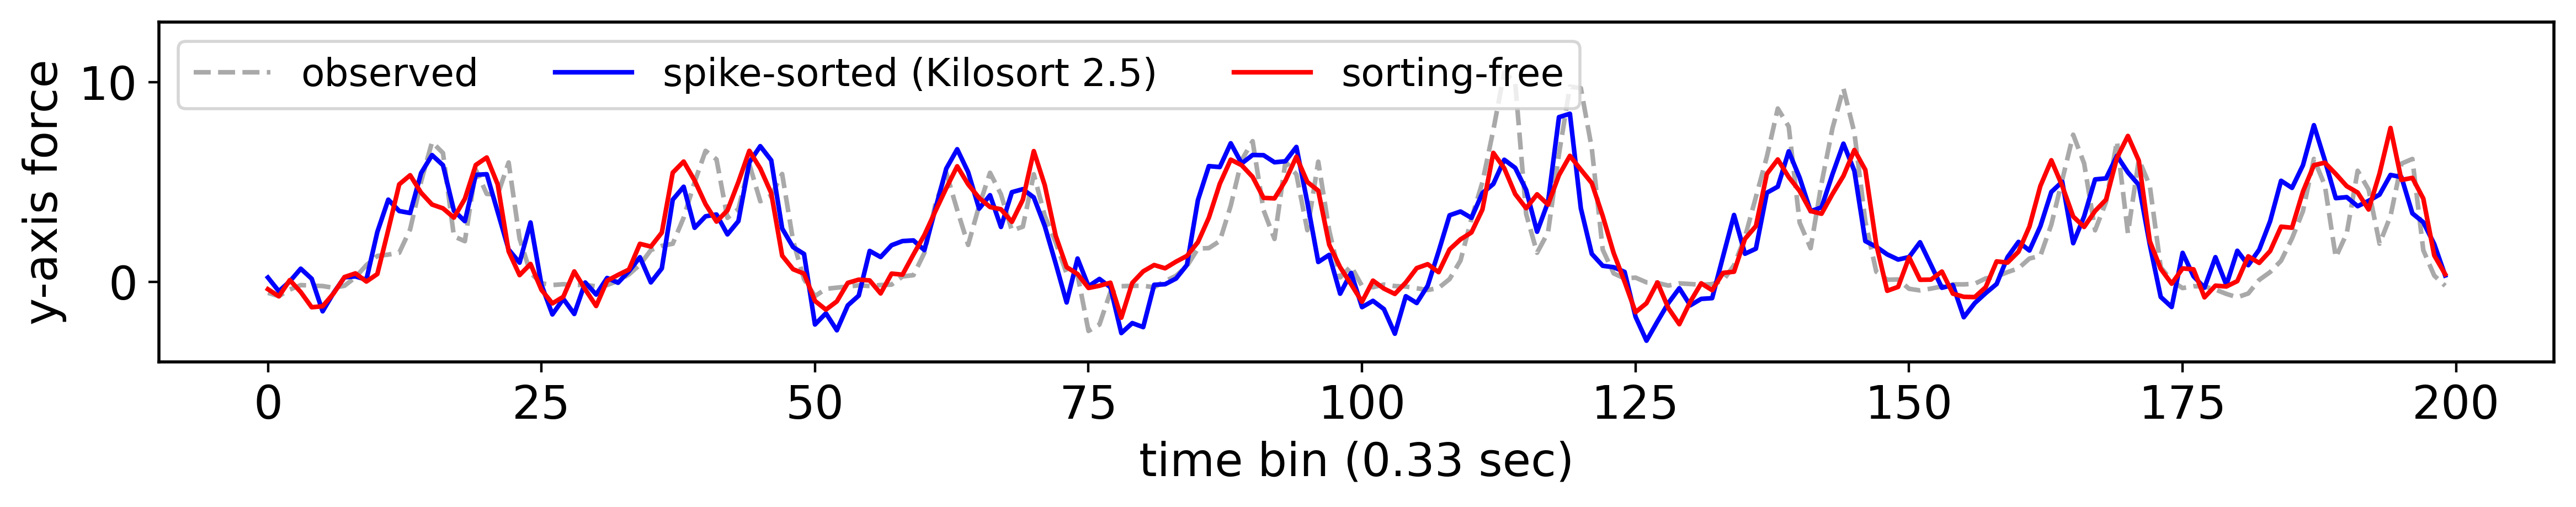

In [22]:
plt.figure(figsize=(14,2))
plt.plot(y_test.flatten()[:200], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred.flatten()[:200], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(our_pred.flatten()[:200], c="red", linestyle="-", label="sorting-free")
plt.xlabel("time bin (0.33 sec)")
plt.ylabel("y-axis force")
plt.legend(ncol=3, loc="upper left")
plt.ylim(-4, 13)
plt.show()

#### 2. IBL

We also include a tutorial for working with IBL datasets, which are public and free to download.

First, let's prepare the IBL data loader (this function takes a while to pull data from the IBL database). 

In [23]:
pid = "dab512bd-a02d-4c1f-8dbc-9155a163efc0"

ibl_data_loader = IBLDataLoader(
    pid, 
    trial_length = 1.5, 
    n_t_bins = 30
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
found 265 trials from 17.56 to 2310.24 sec.


We can check the available brain regions for decoding:

In [24]:
ibl_data_loader.check_available_brain_regions()

['CA1' 'DG-mo' 'DG-po' 'DG-sg' 'Eth' 'LP' 'PO' 'TH' 'VISam5' 'VISam6a'
 'VPLpc' 'alv' 'cing' 'fp' 'ml' 'or']


We want to decode the following behavioral correlates:
   - **Choice**: binary variable of size (n_trials,)
   - **Motion energy**: continuous variable of size (n_trials, n_time_bins)

In [25]:
choice = ibl_data_loader.process_behaviors("choice")
motion_energy = ibl_data_loader.process_behaviors("motion_energy")

Then, we load the **spike times**, **spike channels** and **spike features**. 

In [26]:
dir_path = Path("/mnt/3TB/yizi/danlab/Subjects/DY_016/subtract_res_wf_pcs/")
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T

Here is a visualization of the spike features:

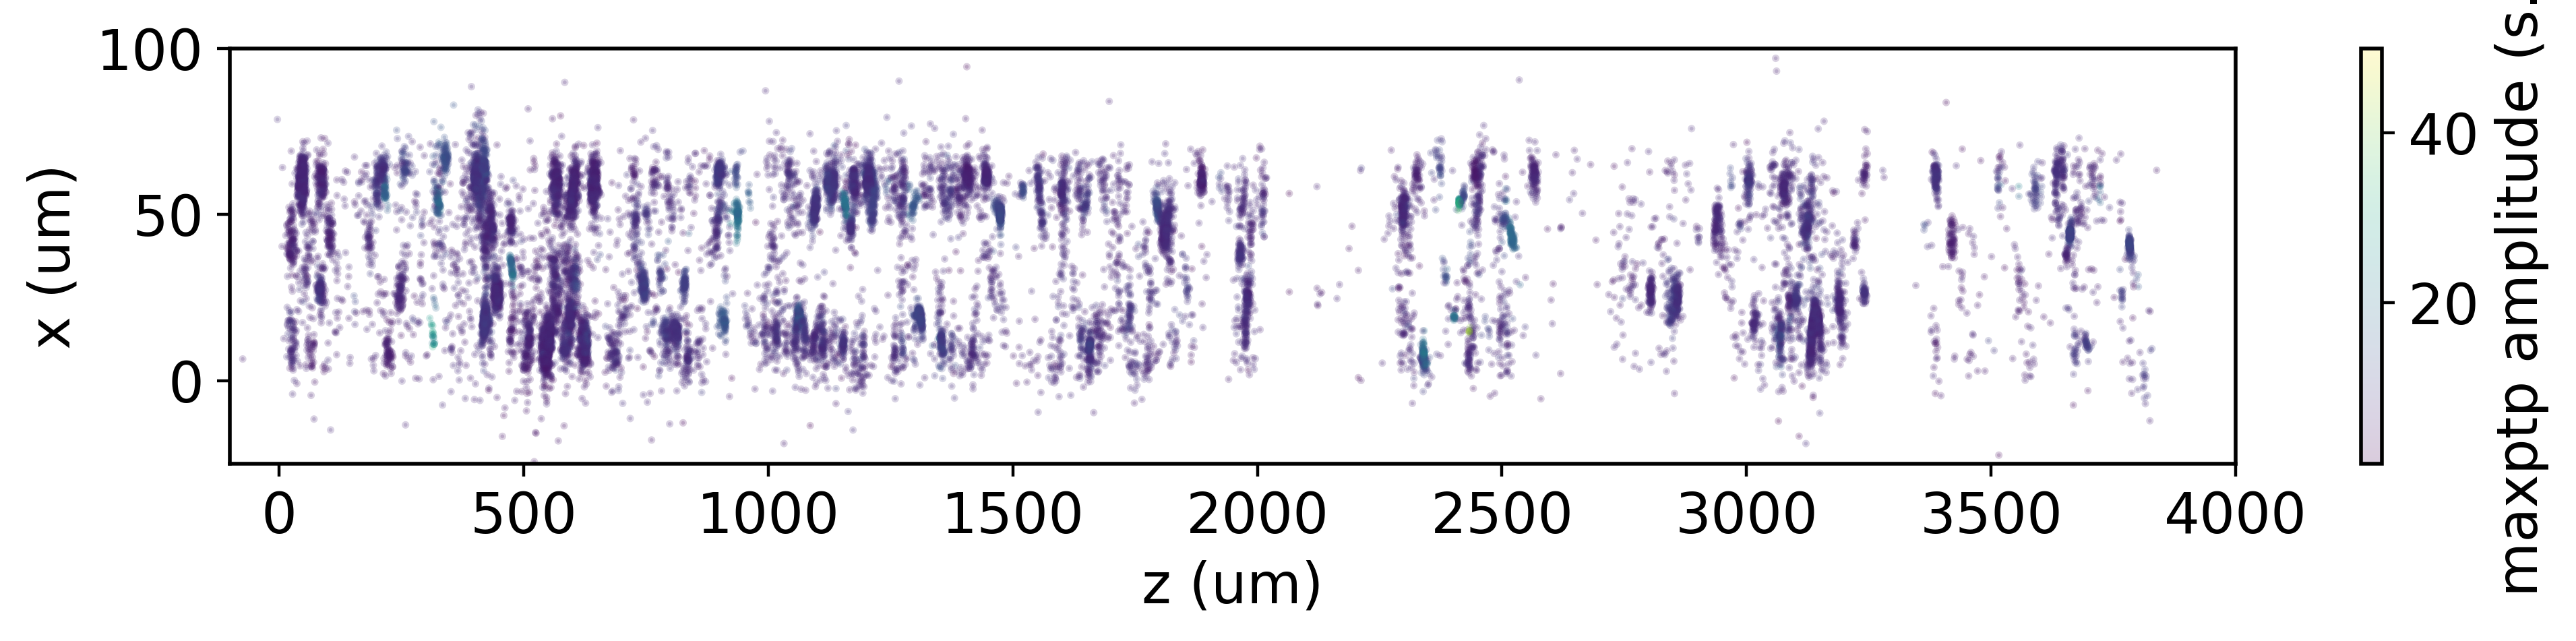

In [27]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-25, 100)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

As an examle, we use spike features from the brain region **LP** to decode motion energy:

In [28]:
brain_region = "lp"

In [29]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 82 channels in region lp


Process spike features: 100%|████████████████| 265/265 [00:01<00:00, 145.75it/s]


Again, multi-unit thresholding is a prerequisite for the decoding pipeline:

In [30]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 82 channels in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 2191.93it/s]


Next, we split the trials into train and test sets:

In [31]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

**And we are ready for density-based decoding :)**

In [32]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = motion_energy,
    behavior_type = "continuous",
    train = train,
    test = test,
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:02<00:00, 35.19it/s]


Initialized a mixture with 112 components.


Train ADVI: 100%|█████████████████████████████| 500/500 [00:05<00:00, 83.43it/s]


time spent: 13.366206407546997 seconds


In [33]:
_, _, our_pred, metrics = sliding_window_decoder(
    weight_matrix, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.461, MSE: 4.299, Corr: 0.682


Now we can load sorting results from Kilosort 2.5 and evaluate its decoding performance:

In [34]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1547.38it/s]


In [35]:
_, y_test, ks_pred, metrics = sliding_window_decoder(
    all_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.480, MSE: 4.148, Corr: 0.693


We visually compare the decoded behavior traces from our method to the spike-sorted decoder:

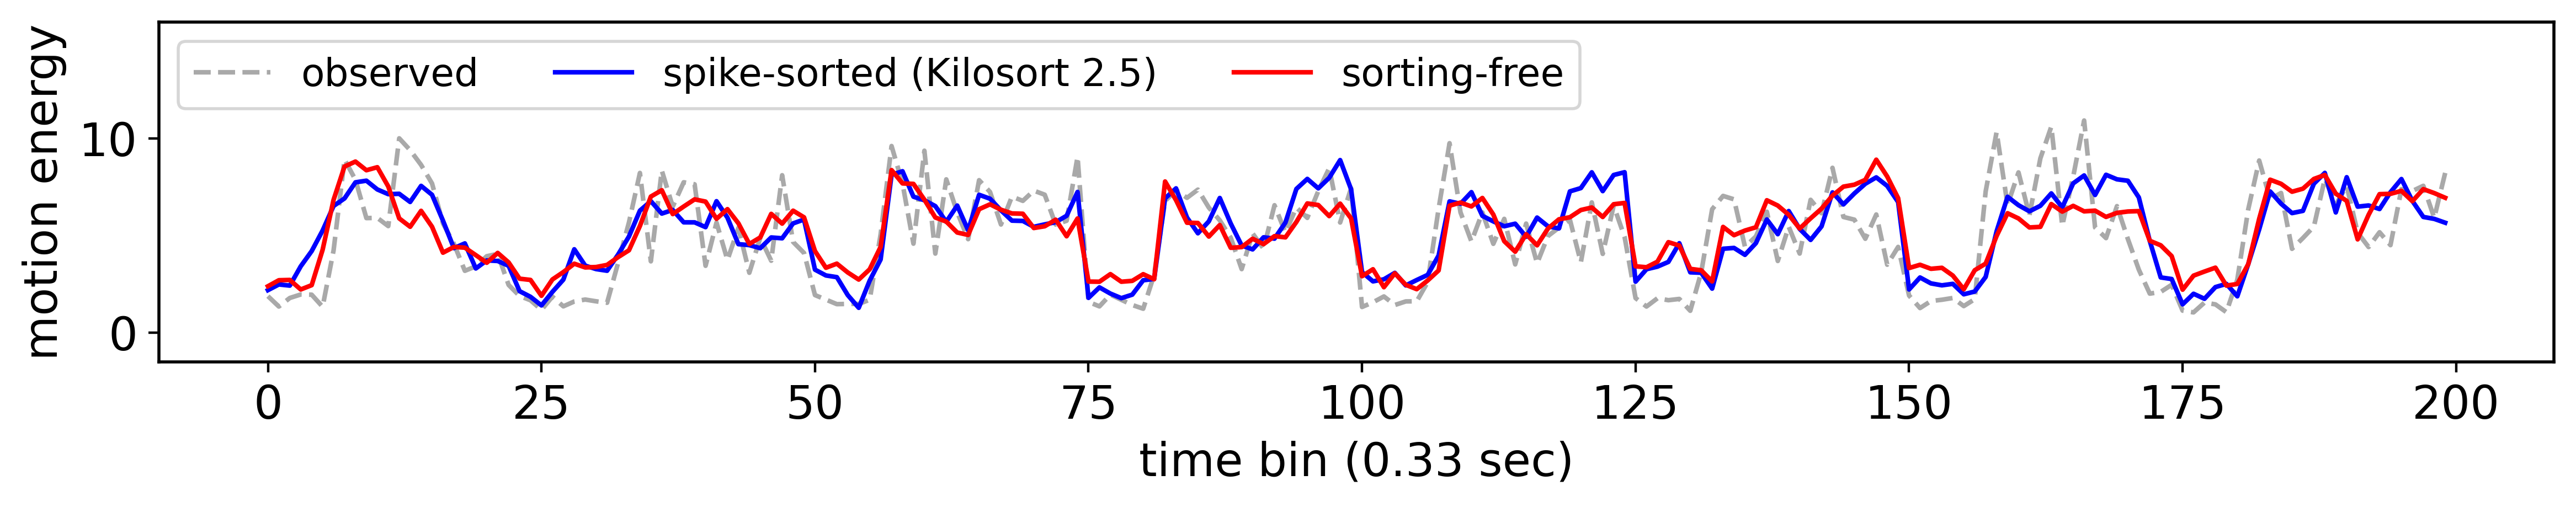

In [36]:
plt.figure(figsize=(14,2))
plt.plot(y_test[:200], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred[:200], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(our_pred[:200], c="red", linestyle="-", label="sorting-free")
plt.xlabel("time bin (0.33 sec)")
plt.ylabel("motion energy")
plt.legend(ncol=3, loc="upper left")
plt.ylim(-1.5, 16)
plt.show()

We can also check how decoding using only **"good" Kilosort units** that pass the quality check does:

In [37]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 20 good units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 6113.67it/s]


In [38]:
_, _, _, _ = sliding_window_decoder(
    good_sorted_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.325, MSE: 5.382, Corr: 0.582


We can also compare our method to spike-thresholded decoder, and ours is better.

In [39]:
_, _, _, _ = sliding_window_decoder(
    thresholded_spike_count, motion_energy, train, test, behavior_type="continuous"
)

R2: 0.415, MSE: 4.665, Corr: 0.645


Moving onto decoding the binary choice. Using a smaller `n_time_bins` usually gives us a higher decoding accuracy.

In [40]:
ibl_data_loader = IBLDataLoader(
    pid, 
    trial_length = 1.5, 
    n_t_bins = 10
)

pulling data from ibl database ..
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
number of trials found: 265 (active: 265)
found 265 trials from 17.56 to 2310.24 sec.


In [41]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )

found 82 channels in region lp


Process spike features: 100%|████████████████| 265/265 [00:01<00:00, 150.59it/s]


In [42]:
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)

found 82 channels in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 2175.04it/s]


In [57]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:02<00:00, 35.04it/s]


Initialized a mixture with 112 components.


Train ADVI: 100%|██████████████████████████████| 50/50 [00:00<00:00, 113.72it/s]


time spent: 4.957310914993286 seconds


In [58]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.906


In [59]:
_, _, _, _ = generic_decoder(
    thresholded_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.792


The choice decoding accuracy from the spike-sorted decoder is:

In [45]:
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)

found 131 Kilosort units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 1525.92it/s]


In [52]:
_, _, _, _ = generic_decoder(
    all_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.925


The accuracy using the decoder based on the "good" Kilosort units is:

In [47]:
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 20 good units in region lp


Compute spike count: 100%|██████████████████| 265/265 [00:00<00:00, 6064.97it/s]


In [53]:
_, _, _, _ = generic_decoder(
    good_sorted_spike_count, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.830


#### 3. CAVI

Although we recommend decoding everything using ADVI as the default inference method, we also include a tutorial for using CAVI for decoding binary behavioral correlates:

In [49]:
start_time = time.time()

weight_matrix = decode_pipeline(
    ibl_data_loader,
    bin_spike_features,
    bin_trial_idxs,
    bin_time_idxs,
    thresholded_spike_count,
    bin_behaviors = choice,
    behavior_type = "discrete",
    train = train,
    test = test,
    inference = "cavi",
)

end_time = time.time()

time_spent = end_time - start_time
print(f"time spent: {time_spent} seconds")

Initialize GMM: 100%|███████████████████████████| 81/81 [00:02<00:00, 35.39it/s]


Initialized a mixture with 112 components.


Compute weight matrix: 100%|██████████████████| 265/265 [00:05<00:00, 52.98it/s]

time spent: 99.36187028884888 seconds


In [55]:
_, _, _, _ = generic_decoder(
    weight_matrix, choice, train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.774
